In [1]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

from utils import *

In [2]:
from unet_model import UNet

In [4]:
# Download the dataset only
# torchvision.datasets.CelebA('./data/', download=True)
# Load the dataset here
# celeba_data = datasets.CelebA(data_root, download=False, transforms=...)

In [5]:
# CelebA
# trainset = torchvision.datasets.CelebA('./data/', split="train", download=False)
# testset = torchvision.datasets.CelebA('./data/', split="test", download=False)

In [4]:
celeb_data_dir = "./data/celeba/img_align_celeba/"
filenames = os.listdir(celeb_data_dir)
paths = []
for filename in filenames:
    paths.append(os.path.join(celeb_data_dir, filename))

In [5]:
torch.from_numpy(np.array(Image.open(paths[0]).convert('L'))).shape

torch.Size([218, 178])

In [6]:
reshape = transforms.Resize(64)

In [7]:
Image.open(paths[0]).convert('L').resize((178,178)).size

(178, 178)

In [8]:
image_length = 178**2

In [9]:
# create the key for encryption
x0 = 0.123456789
alpha = 0.95
key = keygen(sine_map, image_length, x0, alpha)

In [10]:
class CelebData(torch.utils.data.Dataset):
    def __init__(self, img_paths, key):
        self.paths = img_paths
        self.key = key

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, item):
        image_path = self.paths[item]
        img = torch.from_numpy(np.array(Image.open(image_path).convert('L').resize((178,178))))
        img_copy = img.clone()       
        
        encrpyted = encrypt(img_copy, self.key)
        
        X = encrpyted/255
        target = img_copy/255
        
        return X, target

In [11]:
train_data = CelebData(paths[:10000], key)
val_data =  CelebData(paths[10000:], key)

In [12]:
tr_data_loader = DataLoader(
    dataset=train_data,
    batch_size=16,
    num_workers=0,
    shuffle=True
)

va_data_loader = DataLoader(
    dataset=val_data,
    batch_size=16,
    num_workers=0,
    shuffle=True
)

In [13]:
ex = next(iter(tr_data_loader))

In [38]:
epochs = 5
iter_idx = -1
loss = 0

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(1, 1)
model = model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
iter_train_loss = []
for epoch in range(epochs):
    prefix = "Training Epoch {:3d}: ".format(epoch)
    curr_epoch = []
    for data in tqdm(tr_data_loader, desc=prefix, postfix="loss {:8f}".format(loss)):
        iter_idx += 1
        x, y = data
        x = x.to(device).unsqueeze(1)
        y = y.to(device).unsqueeze(1)

        predictions = model(x)
        
        loss = criterion(predictions, y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        iter_train_loss.append(loss.item())

Training Epoch   4: 100%|█████████████████████████████████████████████████████| 625/625 [05:29<00:00,  1.90it/s, loss 0.091892]


In [39]:
x.shape

torch.Size([16, 1, 3, 218, 178])

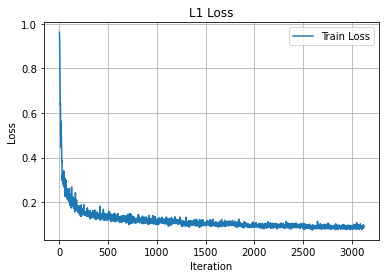

In [40]:
plt.plot(iter_train_loss, label="Train Loss")
plt.title("L1 Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

Text(0.5, 1.0, 'Encrypted Image')

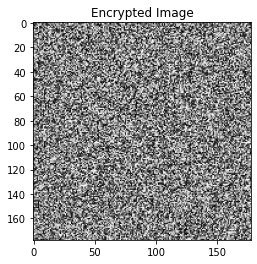

In [41]:
plt.imshow(x[0,0].cpu(), cmap="gray")
plt.title("Encrypted Image")

Text(0.5, 1.0, 'Real Image')

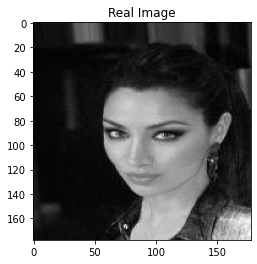

In [42]:
plt.imshow(y[0,0].cpu(), cmap="gray")
plt.title("Real Image")

Text(0.5, 1.0, 'Predicted Image')

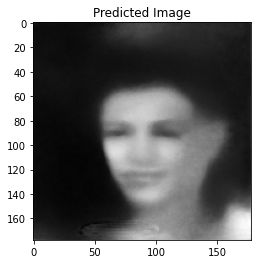

In [43]:
plt.imshow(predictions[0,0].detach().cpu().numpy(), cmap="gray")
plt.title("Predicted Image")

In [44]:
va_loss = []
for data in tqdm(va_data_loader, desc=prefix):
    with torch.no_grad():
        x, y = data
        x = x.to(device).unsqueeze(1)
        y = y.to(device).unsqueeze(1)

        predictions = model(x)

        loss = criterion(predictions, y)
        va_loss.append(loss.item())
    av_va_loss = np.mean(va_loss)

Training Epoch   4: 100%|████████████████████████████████████████████████████████████████████| 193/193 [00:33<00:00,  5.79it/s]


In [36]:
av_va_loss

0.11892536834577205

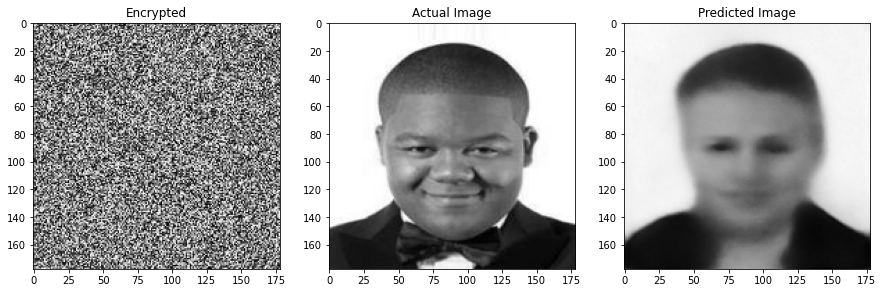

In [53]:
fig = plt.figure(figsize=(15,5))
example = 8

plt.subplot(1, 3, 1)
plt.title("Encrypted")
plt.imshow(x[example,0].cpu(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Actual Image")
plt.imshow(y[example,0].cpu(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Image")
plt.imshow(predictions[example,0].detach().cpu().numpy(), cmap='gray')

plt.show()